## Enhancing Image Classification Performance Through Architectural Exploration and Hyperparameter Tuning on CIFAR-10 Dataset

In [1]:
#import the required packages
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


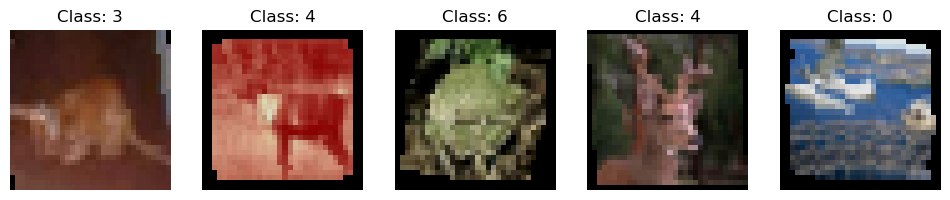

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a random batch of images
def show_images(dataset, num_images=5):
    # Create a random sampler for selecting a batch of images
    sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=num_images)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, sampler=sampler)

    # Fetch a batch of images and labels
    batch = next(iter(data_loader))
    images, labels = batch

    # Denormalize the images for visualization
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))
    images = denormalize(images)

    # Plot the images
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(f'Class: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Display 5 random images
show_images(train_dataset, num_images=5)


In [5]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10, base_channels=32, depth_factor=3, width_factor=2):
        super(ImprovedCNN, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, base_channels * width_factor, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(base_channels * width_factor)

        # List to store convolutional blocks
        self.conv_blocks = nn.ModuleList()

        # Depth variations
        for _ in range(depth_factor):
            self._add_conv_block(base_channels * width_factor)

        # Skip connection
        self.skip_connection = nn.Conv2d(base_channels * width_factor, base_channels * width_factor, kernel_size=1, stride=1, padding=0)

        # Global Average Pooling (GAP)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Fully connected layer
        self.fc = nn.Linear(base_channels * width_factor, num_classes)

    def _add_conv_block(self, in_channels):
        conv_block = self._conv_block(in_channels, in_channels)
        self.conv_blocks.append(conv_block)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Initial convolutional layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm(x)

        # Depth variations with skip connection
        residual = x
        for conv_block in self.conv_blocks:
            x = conv_block(x)

        # Apply 1x1 convolution to the residual to match channels and downsample spatial dimensions
        residual = self.skip_connection(residual)
        residual = F.adaptive_avg_pool2d(residual, (x.size(2), x.size(3)))

        # Add the residual to the output of the convolutional blocks
        x += residual

        x = self.relu(x)

        # Global Average Pooling
        x = self.global_avg_pooling(x)

        # Fully connected layer
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        # Apply softmax activation
        probabilities = F.softmax(logits, dim=1)

        return probabilities

model = ImprovedCNN(num_classes=10, base_channels=32, depth_factor=3, width_factor=2)

In [6]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

In [7]:
#choose an optimizer., Here i am choosing SGD 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [8]:
#Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# Training loop
import torch.nn.functional as F
num_epochs = 10
    
for epoch in range(num_epochs):
    total_correct_train = 0
    total_samples_train = 0
    print(f"Epoch {epoch + 1}/{num_epochs}")
    try:
        model.train()  # Set model to training mode
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            predictions = outputs.argmax(dim=1)
            total_correct_train += (predictions == labels).sum().item()
            total_samples_train += labels.size(0)

        # Calculate accuracy for the entire epoch
        accuracy_train = total_correct_train / total_samples_train

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}, Training Accuracy: {accuracy_train*100:.2f}%")
    except Exception as e:
        print(f"An exception occurred: {e}")


Epoch 1/10
Epoch [1/10] - Loss: 1.9364101886749268, Training Accuracy: 39.89%
Epoch 2/10
Epoch [2/10] - Loss: 1.8754396438598633, Training Accuracy: 55.59%
Epoch 3/10
Epoch [3/10] - Loss: 1.8563275337219238, Training Accuracy: 61.63%
Epoch 4/10
Epoch [4/10] - Loss: 1.9774783849716187, Training Accuracy: 65.70%
Epoch 5/10
Epoch [5/10] - Loss: 1.6893439292907715, Training Accuracy: 68.30%
Epoch 6/10
Epoch [6/10] - Loss: 1.7621469497680664, Training Accuracy: 70.38%
Epoch 7/10
Epoch [7/10] - Loss: 1.6444251537322998, Training Accuracy: 72.12%
Epoch 8/10
Epoch [8/10] - Loss: 1.8247110843658447, Training Accuracy: 73.23%
Epoch 9/10
Epoch [9/10] - Loss: 1.7325525283813477, Training Accuracy: 74.41%
Epoch 10/10
Epoch [10/10] - Loss: 1.7080984115600586, Training Accuracy: 75.17%


In [12]:
#Validate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Accuracy on test set: 79.44%


# Hyperparameter Tuning

In [27]:
from torchvision.datasets import CIFAR10
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset_tuning = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader_tuning = DataLoader(train_dataset_tuning, batch_size=64, shuffle=True, num_workers=4)

val_dataset_tuning = CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader_tuning = DataLoader(val_dataset_tuning, batch_size=64, shuffle=False, num_workers=4)

# Define the hyperparameter search space
param_grid_improved_cnn = {
    'num_classes': [10],
    'base_channels': [32, 64],
    'depth_factor': [2, 3],
    'width_factor': [2, 3],
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid_improved_cnn))

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# Training and validation functions
def train_model(model, train_loader_tuning, optimizer, criterion, device):
    # Your training loop implementation
    model.train()
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for inputs, labels in train_loader_tuning:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}, Training Accuracy: {accuracy_train*100:.2f}%")


def validate_model(model, val_loader_tuning, criterion, device):
    # Your validation loop and accuracy calculation implementation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_tuning:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')
    return accuracy

In [31]:
# Set the number of epochs
num_epochs = 5

best_accuracy = 0.0
best_params = None

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    
    model = ImprovedCNN(**params)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
+
    for epoch in range(num_epochs):
        train_model(model, train_loader_tuning, optimizer, criterion, device)

    accuracy = validate_model(model, val_loader_tuning, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")


Hyperparameter Tuning:   0%|                                                                     | 0/8 [00:00<?, ?it/s]

Epoch 1/5
Epoch [1/5] - Loss: 2.281503200531006, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.2784671783447266, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.2823212146759033, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.2490930557250977, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.2679643630981445, Training Accuracy: 75.17%


Hyperparameter Tuning:  12%|██████▊                                               | 1/8 [1:51:11<12:58:23, 6671.95s/it]

Accuracy on test set: 24.50%
Epoch 1/5
Epoch [1/5] - Loss: 2.2262959480285645, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.263118267059326, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.2638769149780273, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.1831376552581787, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.2840943336486816, Training Accuracy: 75.17%


Hyperparameter Tuning:  25%|█████████████▌                                        | 2/8 [4:47:09<14:55:43, 8957.33s/it]

Accuracy on test set: 28.47%
Epoch 1/5
Epoch [1/5] - Loss: 2.298845052719116, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.2066361904144287, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.1544976234436035, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.2871627807617188, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.133356809616089, Training Accuracy: 75.17%


Hyperparameter Tuning:  38%|████████████████████▎                                 | 3/8 [6:23:32<10:25:40, 7508.12s/it]

Accuracy on test set: 34.02%
Epoch 1/5
Epoch [1/5] - Loss: 2.2046473026275635, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.136115789413452, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.0502476692199707, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.1307756900787354, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.0995845794677734, Training Accuracy: 75.17%


Hyperparameter Tuning:  50%|██████████████████████████                          | 4/8 [11:52:01<13:41:40, 12325.04s/it]

Accuracy on test set: 39.49%
Epoch 1/5
Epoch [1/5] - Loss: 2.287260055541992, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.1904139518737793, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.246518850326538, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.1981875896453857, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.0900931358337402, Training Accuracy: 75.17%


Hyperparameter Tuning:  62%|████████████████████████████████▌                   | 5/8 [15:36:54<10:37:18, 12746.04s/it]

Accuracy on test set: 31.10%
Epoch 1/5
Epoch [1/5] - Loss: 2.2834441661834717, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.222559928894043, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.149503469467163, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.129117965698242, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.2133119106292725, Training Accuracy: 75.17%


Hyperparameter Tuning:  75%|███████████████████████████████████████▊             | 6/8 [23:04:47<9:44:58, 17549.30s/it]

Accuracy on test set: 36.27%
Epoch 1/5
Epoch [1/5] - Loss: 2.2411389350891113, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.3141489028930664, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.1763522624969482, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.0462453365325928, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.08514142036438, Training Accuracy: 75.17%


Hyperparameter Tuning:  88%|██████████████████████████████████████████████▍      | 7/8 [27:40:12<4:46:54, 17214.19s/it]

Accuracy on test set: 39.38%
Epoch 1/5
Epoch [1/5] - Loss: 2.2882895469665527, Training Accuracy: 75.17%
Epoch 2/5
Epoch [2/5] - Loss: 2.057046413421631, Training Accuracy: 75.17%
Epoch 3/5
Epoch [3/5] - Loss: 2.07456636428833, Training Accuracy: 75.17%
Epoch 4/5
Epoch [4/5] - Loss: 2.0788722038269043, Training Accuracy: 75.17%
Epoch 5/5
Epoch [5/5] - Loss: 2.0927321910858154, Training Accuracy: 75.17%


Hyperparameter Tuning: 100%|███████████████████████████████████████████████████████| 8/8 [51:52:30<00:00, 23343.85s/it]

Accuracy on test set: 45.31%
Best Hyperparameters: {'base_channels': 64, 'depth_factor': 3, 'num_classes': 10, 'width_factor': 3}
Best Validation Accuracy: 45.31%
